## Atmospheric River Detection QC  
  
This notebook describes the AR detection outputs and performs some basic QC tasks. Select AR properties are examined through time, and AR property minimum/maximum values, distributions, and pairwise relationships are also explored.

#### Setup:

In [6]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from config import csv_fp, ak_shp, landfall_6hr_fp, landfall_events_fp

In [4]:
#import AR 6hr shapefile and convert time to datetime
ar_6hr = gpd.read_file(landfall_6hr_fp)
ar_6hr['time'] = pd.to_datetime(ar_6hr['time'])

#import AR events shapefile and convert start/end to datetime
ar_events = gpd.read_file(landfall_events_fp)
ar_events['start'] = pd.to_datetime(ar_events['start'])
ar_events['end'] = pd.to_datetime(ar_events['end'])

In [14]:
ar_6hr

,index,time,label,ratio,length,orient,poleward,dir_coher,mean_dir,tot_str,rel_str,crit1,crit2,crit3,crit4,crit5,crit_cnt,geometry
0,3,1992-01-01 06:00:00,2.0,3.5,4854,37,221,87,358,2230418,488,1,1,1,1,1,5,"POLYGON ((-149.62500 61.12500, -149.37500 61.1..."
1,4,1992-01-01 12:00:00,4.0,4.2,3773,38,224,85,0,2233790,443,1,1,1,1,1,5,"POLYGON ((-143.12500 60.62500, -142.62500 60.6..."
2,21,1992-01-08 00:00:00,2.0,3.8,5254,24,232,81,360,3547765,569,1,1,1,1,1,5,"POLYGON ((-145.62500 60.62500, -145.12500 60.6..."
3,22,1992-01-08 06:00:00,2.0,3.7,4862,27,229,83,1,3182008,575,1,1,1,1,1,5,"POLYGON ((-135.87500 58.62500, -134.62500 58.6..."
4,24,1992-01-08 18:00:00,1.0,2.3,4606,12,249,77,1,3141921,530,1,1,1,1,1,5,"POLYGON ((-146.37500 60.62500, -142.37500 60.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8288,19134,2021-12-29 18:00:00,3.0,2.8,3095,26,232,80,357,1847501,454,1,1,1,1,1,5,"POLYGON ((-156.12500 61.87500, -155.12500 61.8..."
8289,19136,2021-12-30 00:00:00,3.0,2.6,2986,33,228,74,355,2094112,428,1,1,1,1,1,5,"POLYGON ((-155.37500 59.12500, -150.37500 59.1..."
8290,19138,2021-12-30 06:00:00,2.0,2.2,2875,39,224,80,359,1907705,423,1,1,1,1,1,5,"POLYGON ((-154.62500 58.87500, -153.87500 58.8..."
8291,19141,2021-12-31 00:00:00,2.0,2.1,2712,38,210,86,360,1147189,384,1,1,1,1,1,5,"POLYGON ((-160.37500 60.87500, -159.37500 60.8..."


In [7]:
pd.read_csv(csv_fp)

,time,time.1
0,blob_label,label
1,geometry,geometry
2,length/width ratio,ratio
3,major axis length (km),length
4,overall orientation,orient
5,mean poleward strength,poleward
6,directional_coherence,dir_coher
7,mean_of_ivt_dir,mean_dir
8,total ivt strength,tot_str
9,relative ivt strength,rel_str


#### Define attributes:  
  
##### LANDFALLING AR 6HR OUTPUT  
  
**index** : index of landfalling timestep AR in the full AR output  
**time** : timestep of AR  
**label** : original candidate region label of timestep AR  
**ratio** : length to width ratio of timestep AR 
**length** : length (km) of timestep AR  
**orient** : orientation of timestep AR  
**poleward** : poleward strength of timestep AR  
**dir_coher** : directional coherence (%) of timestep AR  
**mean_dir** : mean IVT direction of timestep AR  
**tot_str** : sum of IVT within timestep AR  
**rel_str** : sum of relative IVT (sum IVT/area) within timestep AR  
**crit1** : Coherence in IVT direction (1 = True / 0 = False)  
**crit2** : Mean Meridional IVT (1 = True / 0 = False)  
**crit3** : Consistency Between Mean IVT Direction and Overall Orientation  
**crit4** : Length (1 = True / 0 = False)  
**crit5** : Length/Width Ratio (1 = True / 0 = False)  
**crit_cnt** : Number of criteria passed  
**geometry** : geometry of timestep AR  
  
##### LANDFALLING AR EVENTS OUTPUT  
  
**start** : first timestep of AR event  
**end** : last timestep of AR event  
**sumtot_str** : sum of IVT across all timestep ARs in event  
**sumrel_str** : sum of relative IVT (sum IVT/area) across all timestep ARs in event  
**ratio_m** : mean length to width ratio across all timestep ARs in event  
**len_km_m** : mean length (km) across all timestep ARs in event  
**orient_m** : mean orientation across all timestep ARs in event  
**poleward_m** : mean poleward strength across all timestep ARs in event   
**dircoher_m** : mean directional coherence (%) across all timestep ARs in event  
**mean_dir_m** : mean IVT direction across all timestep ARs in event  
**dur_hrs** : duration of AR event  
**tintensity** : sum of AR event total intensity divided by AR event duration  
**rintensity** : sum of AR event relative intensity divided by AR event duration  
**geometry** : geometry of AR event polygons

In [9]:
gdf = ar_events

Text(0.5, 0.98, 'Landfalling AR Events: Count per Month')

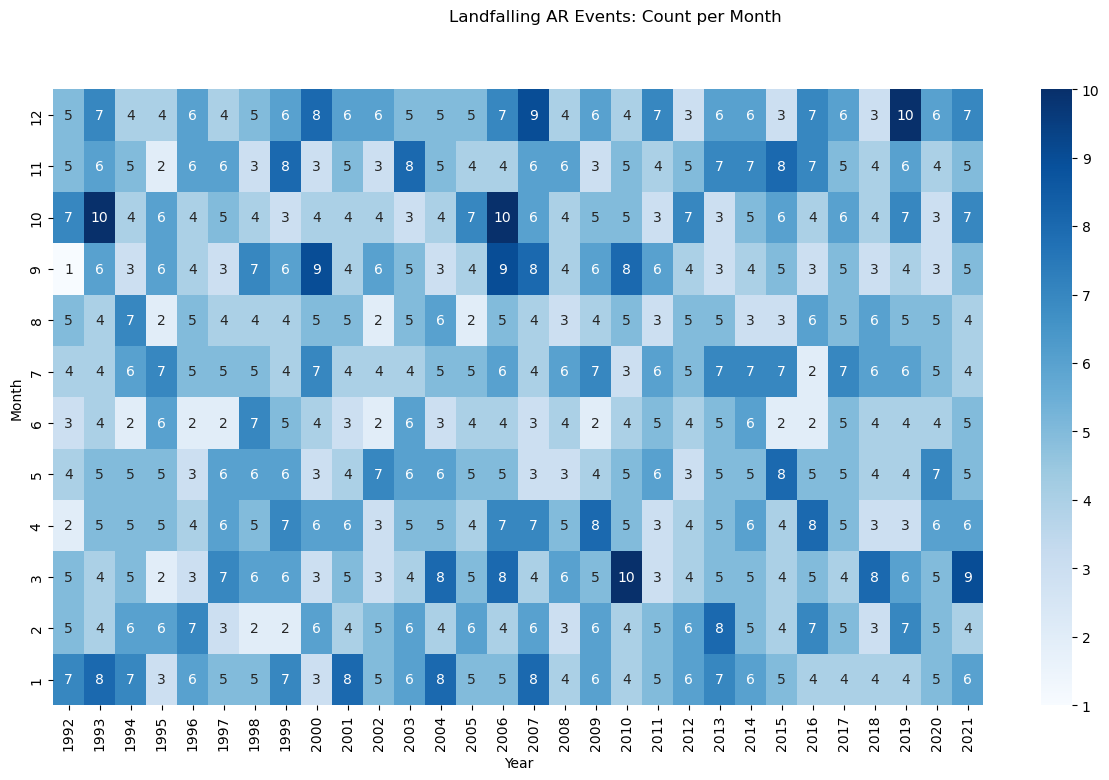

In [10]:
gdf["Year"] = gdf.start.apply(lambda x: x.year)
gdf["Month"] = gdf.end.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="index", aggfunc="count").fillna(0)

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(pt, annot=True, ax=ax, cmap='Blues')
ax.invert_yaxis()
fig.suptitle('Landfalling AR Events: Count per Month')

In [11]:
gdf['rintensity_dev'] = gdf['rintensity'] - gdf['rintensity'].mean()
gdf['rintensity_dev']

0       16.664817
1      -12.335183
2       18.664817
3      -28.335183
4      -32.335183
          ...    
1797   -36.335183
1798    29.664817
1799     4.664817
1800    15.664817
1801   -10.335183
Name: rintensity_dev, Length: 1802, dtype: float64

Text(0.5, 0.98, 'Landfalling AR Events: Monthly Max Deviation from Dataset Relative Intensity Mean')

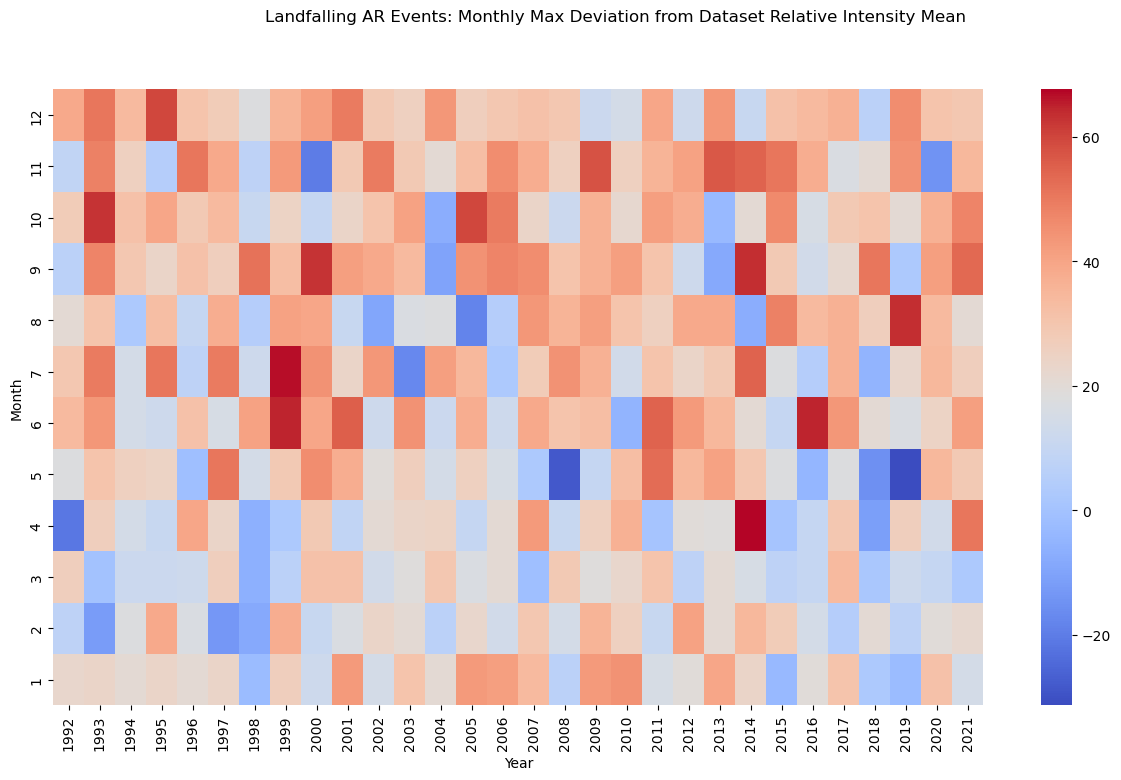

In [18]:
gdf["Year"] = gdf.start.apply(lambda x: x.year)
gdf["Month"] = gdf.start.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="rintensity_dev", aggfunc="max").fillna(0)

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(pt, annot=False, ax=ax, cmap='coolwarm')
ax.invert_yaxis()
fig.suptitle('Landfalling AR Events: Monthly Max Deviation from Dataset Relative Intensity Mean')

Text(0.5, 0.98, 'Landfalling AR Events: Monthly Max Duration')

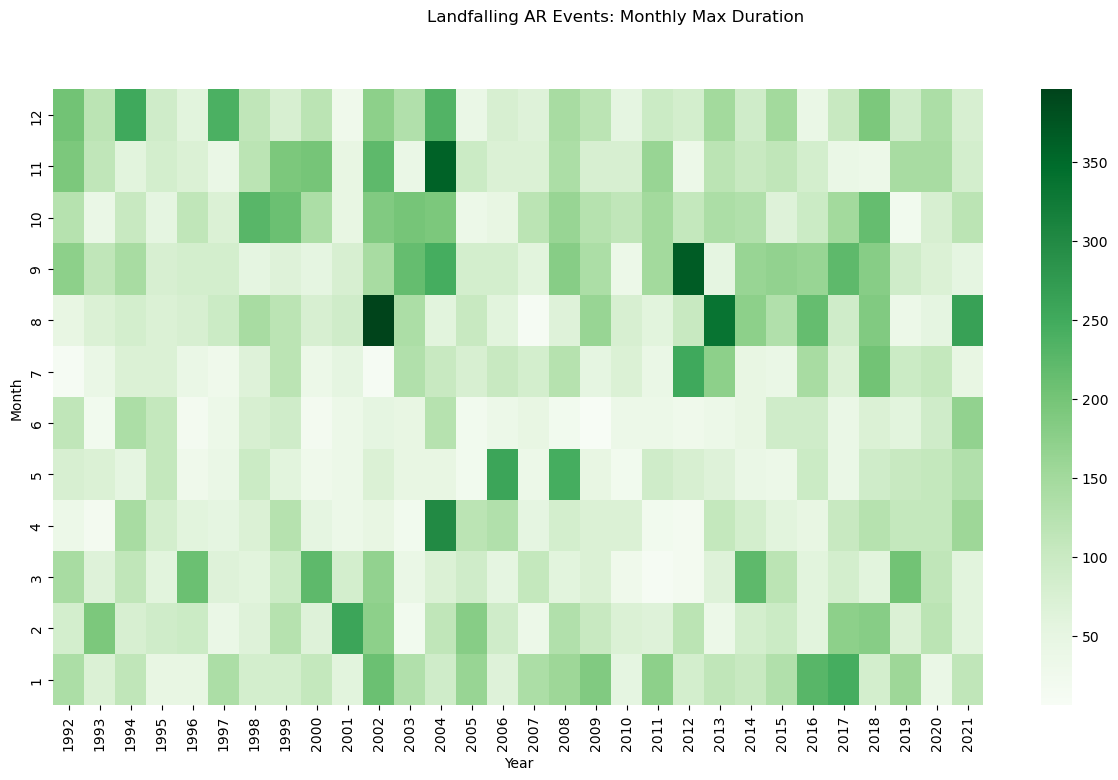

In [12]:
gdf["Year"] = gdf.start.apply(lambda x: x.year)
gdf["Month"] = gdf.start.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="dur_hrs", aggfunc="max").fillna(0)

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(pt, annot=False, ax=ax, cmap='Greens')
ax.invert_yaxis()
fig.suptitle('Landfalling AR Events: Monthly Max Duration')

Text(0.5, 1.1, 'Pairplot of Select Landfall AR Properties')

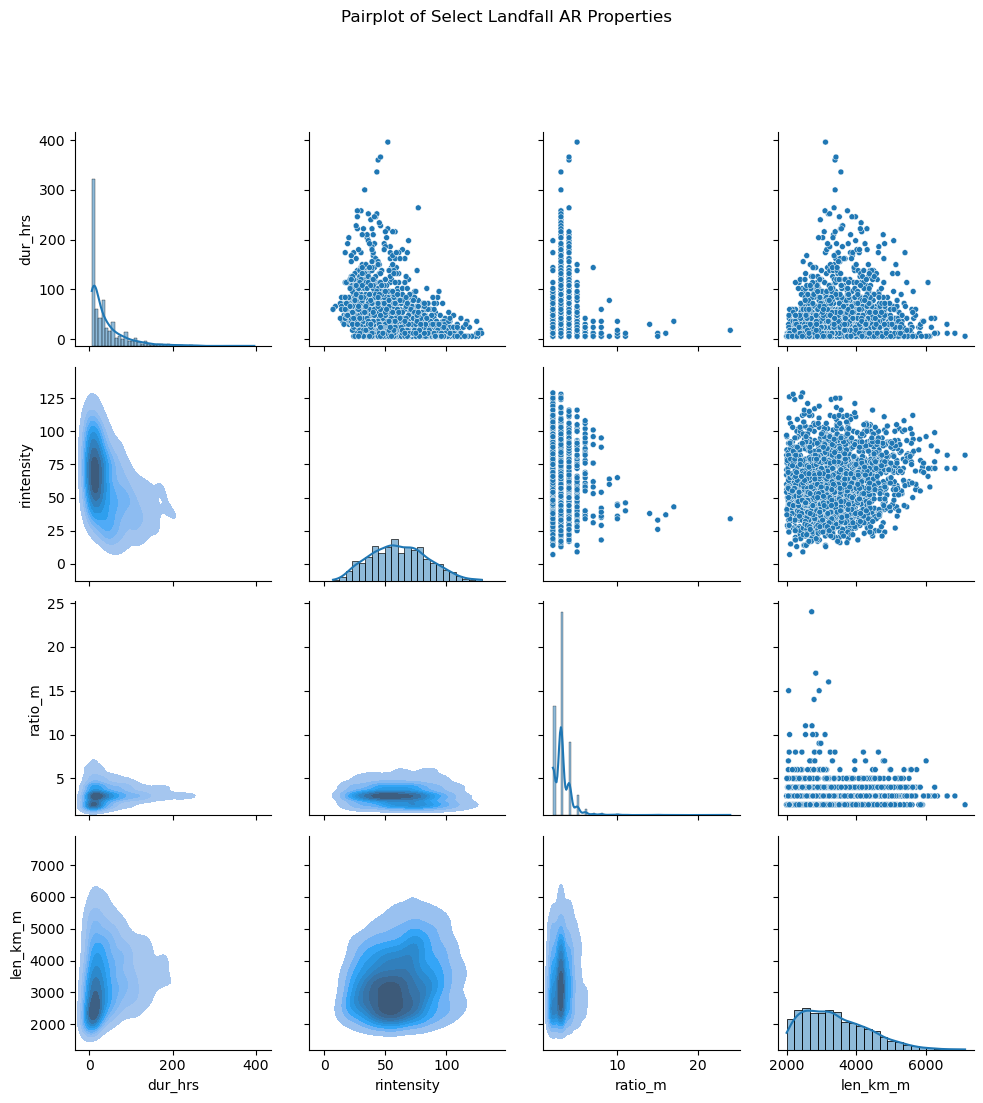

In [13]:
sub = gdf[['dur_hrs', 'rintensity', 'ratio_m', 'len_km_m']]
#sub = sub[sub['ratio'] < 12]

g = sns.PairGrid(sub)
g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

g.fig.suptitle('Pairplot of Select Landfall AR Properties', y=1.1)